<a href="https://colab.research.google.com/github/javajaewook/Jaewook-Lee/blob/master/DL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
link = '/content/gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from google.colab import output as sound

def beepsound():
  sound.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

(0) gdrive에 연결한다

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.tensor
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

# hyper parameters
batch_size = 8
learning_rate = 0.002
num_epoch = 1

(1) CIFAR10 train, test dataset 가져오기

In [3]:
cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test = dset.CIFAR10(link+"CIFAR10/", train = False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


(2) 데이터 확인

length of cifar_train:  50000
length of cifar_test:  10000
shape of image data:  torch.Size([3, 32, 32])
label:  9


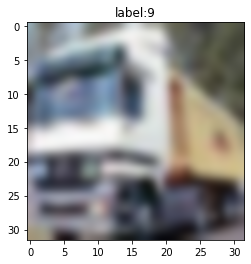

In [4]:
print("length of cifar_train: ", len(cifar_train))
print("length of cifar_test: ", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("shape of image data: ", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label:%d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

정확도 검사용 함수 정의


In [0]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0
  for j, [imgs, labels] in enumerate(dloader):
    img =  torch.Tensor(imgs).requires_grad_(True).cuda()
    #img = torch.Tensor.requires_grad_(imgs),cuda()
    #img = Variable(imgs, volatile=True).cuda()
    label = torch.Tensor.detach_(labels).cuda()
    #label = Variable(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}" .format(100*correct/total))

데이터를 로드하고, 모델을 선언



In [0]:
# === data load function ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [0]:
# === declare CNN model ===
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(100),
        nn.Linear(100,10)
    )
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size, -1)
    out=self.fc_layer(out)

    return out

In [0]:
model=CNN().cuda()

In [9]:
# === loss, optimizer ===
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(),lr=learning_rate) # (5) Adam optimizer

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) # (6) learning rate decay

# === training ===
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x= torch.Tensor(image).requires_grad_(True).cuda()
    y_= torch.Tensor.detach_(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output, y_)
    loss.backward()
    optimizer.step()

    if (j%1000==0):
      print(j,loss)
  if (i%100==0):
    print("epoch: {}".format(i))

0 tensor(2.3173, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(2.2758, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(2.2463, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(2.0754, device='cuda:0', grad_fn=<NllLossBackward>)
4000 tensor(2.5088, device='cuda:0', grad_fn=<NllLossBackward>)
5000 tensor(1.8224, device='cuda:0', grad_fn=<NllLossBackward>)
6000 tensor(1.7686, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 0


Naive Test

In [10]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 31.259998321533203


In [0]:
# === (1) data augmentation ===
cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, 
                           transform=transforms.Compose([
                                                         transforms.Resize(36),
                                                         transforms.CenterCrop(32),
                                                         transforms.RandomHorizontalFlip(),
                                                         transforms.Lambda(lambda x: x.rotate(90)),
                                                         transforms.ToTensor()                          
])) # 데이터 증식
cifar_test = dset.CIFAR10(link+"CIFAR10/", train = False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified


In [0]:
# === (2) Weight initialization ===
# === data load function ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === declare CNN model ===
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        #nn.BatchNorm2d(100),
        nn.Linear(100,10)
    )
    for m in self.modules():
      if (isinstance(m,nn.Conv2d)):
        init.kaiming_normal_(m.weight.data) # ReLU 일 때
        m.bias.data.fill_(0)
      if (isinstance(m,nn.Linear)):
        init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0)
  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size, -1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

In [0]:
# === (3) data normalization ===
cifar_train = dset.CIFAR10(link+"CIFAR10/", train = True, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                                         ])
                           , target_transform=None, download=False)
cifar_test = dset.CIFAR10(link+"CIFAR10/", train = False, transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                                                         ]), target_transform=None, download=False)